Zajęcia z Praktycznego Machine Learningu w Pythonie. WNE UW. 2021
Student: Aleksander Ostruk

# Zbiór danych: cena wynajmu mieszkań w Warszawie
Możliwe użycie:
* Znajdź najlepsze mieszkanie dopasowane do budżetu
* Wyceń swoje mieszkanie na wynajem
* Oceń parametry mieszkania które najbardziej wpływają na jego cenę
* Znajdź średnie ceny dla grup mieszkań


In [2]:
# Zmienne pomocnicze, konfiguracja i parametry
results_folder = 'results/'

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Eksploracja danych

In [3]:
import pandas as pd
import pandas_profiling
df = pd.read_csv("dane mieszkania/data_clean.csv")
print(df.shape)
df.head()

(3472, 85)


,area,room_num,floor,total_floor,year_built,poddasze,dish_washer(zmywarka),fridge(lodówka),furniture(meble),oven(piekarnik),...,district_ Warszawa,district_ Wawer,district_ Wesoła,district_ Wilanów,district_ Wola,district_ Włochy,district_ mazowieckie,district_ Śródmieście,district_ Żoliborz,gross_price
0,37.0,2.0,1.0,4.000000,2001.453488,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2435.244186
1,38.0,2.0,1.0,5.802326,2020.000000,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2175.000000
2,57.0,3.0,1.0,15.000000,1984.000000,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3300.000000
3,63.0,2.0,4.0,5.000000,2005.000000,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2585.046512
4,65.0,3.0,3.0,4.000000,1938.000000,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3424.918605


In [2]:
report = df.profile_report()
report.to_file(output_file=f"{results_folder}report_rent_price.html")

#### Podsumowanie raportu

##### Najbardziej problematyczne zmienne (usuwamy):
* constants: only_for_non_smokers, garage, closed_area, monitoring, intercom, secure_dorrs, 


##### 7 duplikatów (0.2%)

##### 0 pominiętych rekordów

##### brak wartości odstających
Jest kilka ofert odstających o np. dużej powierzchni ok 150m kw. lub piętrze >30, cenie > 1500. Lecz uznajemy takie wartości za przydatne a nie odstające


In [4]:
df.columns
columns = ['only_for_non-smokers(tylko_dla_niepalących)', 
           'garage/parking_space(garaż/miejsce_parkingowe)', 
           'closed_area(teren_zamknięty)', 
           'monitoring/security(monitoring/ochrona)', 
           'intercom/videophone(domofon/wideofon)', 
           'secure_doors/windows(drzwi/okna_antywłamaniowe)']
df.drop(columns, inplace=True, axis=1)

#Zmieńmy nazwy kolumn na tylko angielskie:
df.rename(columns={c:c.replace(' ', '').split('(', 1)[0] for c in df.columns}, inplace=True)

df.rename(columns={'build_type_Private_house_1+_fam':'szeregowiec', 
                   'build_type_Private_house_1_fam':'wolnostojacy', 
                   'build_type_Loft/attic':'loft',
                  'anti-burglaryblinds':'anti_burglaryblinds',
                  'two-level':'two_level',
                  'district_Praga-Południe':'district_Praga_Południe',
                  'district_Praga-Północ':'district_Praga_Północ'}, inplace=True)

df.drop_duplicates()
features = df.columns.tolist()
target = "gross_price"
numFeatures = ['area']

try:
    features.remove(target)
    numFeatures.remove(target)
except ValueError:
    pass  # do nothing!

catFeatures = [f for f in features if f not in numFeatures]

In [102]:
# Zbiór nie jest zrównoważony
# Możemy rozważyć wylączenie kategorii niereprezentatywnych, lub odniesienie ich (polączenie) w bardziej ogólne
print(df.groupby('district')['gross_price'].count().sort_values(ascending=False))

district
district_Mokotów            647
district_Wola               512
district_Śródmieście        342
district_Praga_Południe     239
district_Ursynów            205
district_Ochota             201
district_Bielany            166
district_Bemowo             155
district_Białołęka          155
district_Praga_Północ       135
district_Wilanów            125
district_Targówek           116
district_Żoliborz           105
district_Ursus               97
district_Włochy              77
district_Centrum             60
district_mazowieckie         44
district_Wawer               42
district_Warszawa            19
district_Wesoła              14
district_Rembertów           14
district_MetroWilanowska      2
Name: gross_price, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


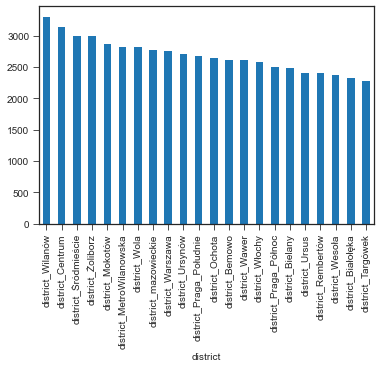

In [95]:
# Trochę jeszcze statystyk dla lepszego wlądu w dane
# JAKA ŚREDNIA CENA MIESZKANIA W DZIELNICY?
df["district"] = df[[f for f in features if f.startswith('district')]].idxmax(axis=1)
srednia_cena = df.groupby('district')['gross_price'].mean().sort_values(ascending=False)
print(srednia_cena.plot.bar(x='Średnia cena w dzielnicy'))

AxesSubplot(0.125,0.125;0.775x0.755)


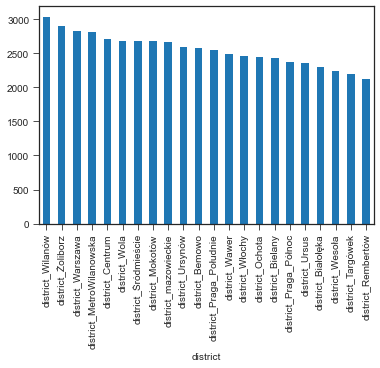

In [96]:
print(df.groupby('district')['gross_price'].median().sort_values(ascending=False).plot.bar(x='Mediana ceny w dzielnicy'))
# JAKA MEDIANA CENY MIESZKANIA W DZIELNICY?

AxesSubplot(0.125,0.125;0.775x0.755)


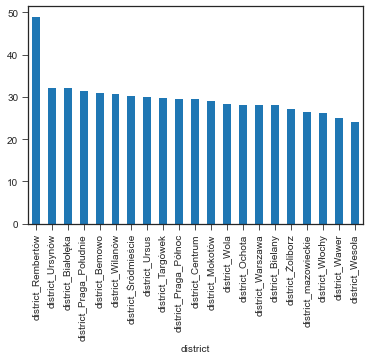

In [98]:
# JAKA ŚREDNIA WIELKOŚĆ KAWALERKI W DZIELNICY?
print(df[df['room_num']==1].groupby('district')['area'].mean().sort_values(ascending=False).plot.bar(x='nŚREDNIA dzielnica ile ma pokój'))

AxesSubplot(0.125,0.125;0.775x0.755)


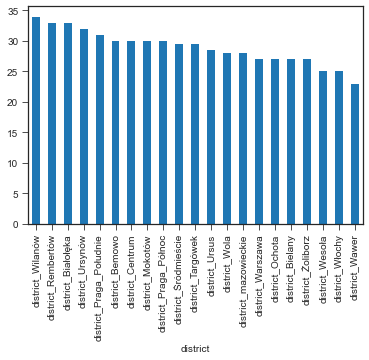

In [99]:
# JAKA MEDIANA WIELKOŚCI KAWALERKI W DZIELNICY?
print(df[df['room_num']==1].groupby('district')['area'].median().sort_values(ascending=False).plot.bar(x='nŚREDNIA dzielnica ile ma pokój'))

## Model regresji liniowej

Próbujemy oszacować cenę mieszkania w najprostszy możliwy sposób

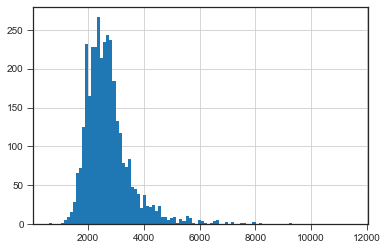

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

from IPython.display import display

# Obejrzyjmy histogram zmiennej objaśnianej
df.gross_price.hist(bins=100)
plt.show()

In [7]:
import statsmodels.formula.api as smf
# Takie zmienne jak lodówka, poddasze czy meble mogą nie mieć sensu ponieważ zbiory są mocno znierównoważone
# dla tych zmiennych (większość ma lodówkę, nie ma poddasza, ma meble)
formula_full = 'gross_price ~ ' + ' + '.join(features)
mod = smf.ols(formula = formula_full, data = df)
res = mod.fit()
summary = res.summary()
with open(f"{results_folder}/regresja_rent_prices.txt", "w") as fp:
    fp.write(str(summary))
    print(summary)

                            OLS Regression Results                            
Dep. Variable:            gross_price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     112.0
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:18:26   Log-Likelihood:                -26494.
No. Observations:                3472   AIC:                         5.314e+04
Df Residuals:                    3394   BIC:                         5.362e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Komentarz
Widać, że wiele zmiennych takich jak floor, year_built, fridge, district_mazowieckie, furniture, oven, stove, balcony, basement może być nieistotnych

Wylączmy niektóre z nich, te które wydają się być rzeczywiście niereprezentatywne

Tworzymy inną grupę zmiennych objaśniających bez nich, będziemy testować oba warianty


## Ciekawe spostrzerzenia
* Cecha Renowation (do odnowienia) istotnie niegatywnie wpływa na wynik aż o -1074.4333 zł (czego można było oczekiwać)
* Natomiast inny przypadek - cecha Loft (styl mieszkania) istotnie pozytywnie wpływa aż o 1469.1314 zł.
* Owszem mieszkania zlokalizowane w śródmieściu (o tych samych pozostałych parametrach) są średnio droższe o 456.77 zł.
* A te zlokalizowane w Rembertowie są średnio tańsze o 538.14 zł przy pozostałych cechach niezmienionych
* availableforstudents obniża cenę (lub: oferty dla studentów są tańsze)
* alarmsystem obniża cenę (niebezpieczny rejon?)
* telefon, meble czy internet nie mają istotnego wpływu na końcową cenę

In [103]:
features_insignificant = ['fridge', 
                          'district_mazowieckie', 
                          'furniture', 
                          'oven', 
                          'stove', 
                          'heating_Electric', 
                          'telephone', 
                          'internet', 
                          'heating_Boiler',
                          'build_mat_Autoclaved_aerated_concrete', 
                         '']
features_significant = [f for f in features if f not in features_insignificant]

## Uniwersalne funkcje dla modeli skitlearn

Zdefiniujmy powtarzalny schemat dla łatwiejszego testowania modeli z różnymi parametrami

In [109]:
#importy
import json
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from pprint import pprint
import operator

In [12]:
# funkcja budująca listę argumentów do przekazania (uwaga-kolejność ma znaczenie, ma być taka jak dla modelu)
def build_params_list(array_of_arrays):
    if len(array_of_arrays)==1:
        for param in array_of_arrays[0]:
            yield [param]
    else:
        for param in array_of_arrays[0]:
            for p in build_params_list(array_of_arrays[1:]):
                yield [param] + p

In [13]:
# funkcja budująca słownik argumentów do przekazania
def build_params_dict(dict_of_list):
    for k in dict_of_list:
        for param in dict_of_list[k]:
            yield {k:param}


In [125]:
# implementacja grid search - przekazujemy model, zakres parametrów do wytestowania oraz specyfikacje kfolda. 
# Funkcja przelatuje po wszystkich możliwych kombinacjach, zapisując wyniki do wskazanego pliku
def grid_search(array_of_arrays, 
                model_function, 
                kfold_repeats=3, 
                kfold_splits=5, 
                results_filename='randomForestModels',
               features_train=features,
               feature_predicted=target,
               dataset=df):
    models_configs = []
    all_params_sets = [ps for ps in build_params_list(array_of_arrays)]
    iteration = 0
    for params_list in all_params_sets:
        model = model_function(*params_list)
        models_config = {'params':model.get_params()}
        # evaluate the model
        scores_to_apply = ['neg_mean_absolute_error', 'max_error', 'r2', 'explained_variance']
        cv = RepeatedKFold(n_splits=kfold_splits, n_repeats=kfold_repeats, random_state=1)
        scores = cross_validate(model, 
                                dataset[features_train].values, 
                                dataset[feature_predicted].values, 
                                scoring=scores_to_apply, 
                                cv=cv, n_jobs=-1, error_score='raise')
        
        for s in scores_to_apply:
            models_config[f'{s}_mean'] = mean(scores[f'test_{s}'])
            models_config[f'{s}_std'] = std(scores[f'test_{s}'])

        print(f'Iteration {iteration} of {len(all_params_sets)} for {results_filename} with {len(features_train)} features: R2: {mean(scores["test_r2"])}')
        iteration += 1
        models_configs.append(models_config)
    #save model results to json
    with open(f"{results_folder}{results_filename}.json", 'w') as outfile:
        json.dump(models_configs, outfile)
        return models_configs

In [137]:
def print_best_params(models_configs):
    best = max(models_configs, key=lambda item: item['r2_mean'])
    print("\n+=====================+")
    print("Best model results:")
    pprint(best)
    print("+=====================+\n")

## Regresja liniowa skitlearn

In [138]:
# Liniowa bez regularyzacji
linear_models =  grid_search([[True, False], [True, False]], model_function=linear_model.LinearRegression, results_filename='linear')
print_best_params(linear_models)
linear_models_limited =  grid_search([[True, False], [True, False]], model_function=linear_model.LinearRegression, results_filename='linearSignificant', features_train=features_significant)
print_best_params(linear_models)

Iteration 0 of 4 for linear with 78 features: R2: -3.740422346747629e+26
Iteration 1 of 4 for linear with 78 features: R2: 0.6867231817336287
Iteration 2 of 4 for linear with 78 features: R2: 0.6863775451085169
Iteration 3 of 4 for linear with 78 features: R2: 0.6863775451085169

+=====================+
Best model results:
{'explained_variance_mean': 0.6871706944437838,
 'explained_variance_std': 0.03885963749137075,
 'max_error_mean': -4340.98642354953,
 'max_error_std': 947.3372211622649,
 'neg_mean_absolute_error_mean': -351.8007689517848,
 'neg_mean_absolute_error_std': 11.28131758913344,
 'params': {'copy_X': True,
            'fit_intercept': True,
            'n_jobs': None,
            'normalize': False},
 'r2_mean': 0.6867231817336287,
 'r2_std': 0.03888377582188019}
+=====================+

Iteration 0 of 4 for linearSignificant with 70 features: R2: -1.4969561637758443e+25
Iteration 1 of 4 for linearSignificant with 70 features: R2: 0.6883179017906744
Iteration 2 of 4 for l

In [19]:
# Regresja liniowa z regularyzacją
linear_lasso_models =  grid_search([[0.5, 1.0, 2.0, 5.0], [True, False], [True, False]], model_function=linear_model.Lasso, results_filename='linearLasso')
print_best_params(linear_lasso_models)

linear_ridge_models =  grid_search([[0.5, 1.0, 2.0, 5.0, 10.0], [True, False], [True, False]], model_function=linear_model.Ridge, results_filename='linearRidge')
print_best_params(linear_ridge_models)

linear_elastic_net_models =  grid_search([[0.5, 1.0, 2.0, 5.0, 10.0], [0.2, 0.5, 0.9], [True, False], [True, False]], model_function=linear_model.ElasticNet, results_filename='linearElasticNet')
print_best_params(linear_elastic_net_models)


Iteration 0 of 16: R2 is 0.6800088534537618
Iteration 1 of 16: R2 is 0.6904909107383423
Iteration 2 of 16: R2 is 0.6806680853405059
Iteration 3 of 16: R2 is 0.6806680853405059
Iteration 4 of 16: R2 is 0.6555181871268265
Iteration 5 of 16: R2 is 0.6923133364313477
Iteration 6 of 16: R2 is 0.6802989450699258
Iteration 7 of 16: R2 is 0.6802989450699258
Iteration 8 of 16: R2 is 0.6066603823625587
Iteration 9 of 16: R2 is 0.6915057608613606
Iteration 10 of 16: R2 is 0.6790564210271255
Iteration 11 of 16: R2 is 0.6790564210271255
Iteration 12 of 16: R2 is 0.504895827350338
Iteration 13 of 16: R2 is 0.6834550642003802
Iteration 14 of 16: R2 is 0.6704872803593833
Iteration 15 of 16: R2 is 0.6704872803593833
Best model results:
{'neg_abs_error_mean': -346.1872121674694,
 'neg_abs_error_std': 11.777086435628755,
 'params': {'alpha': 1.0,
            'copy_X': True,
            'fit_intercept': True,
            'max_iter': 1000,
            'normalize': False,
            'positive': False,
    

In [ ]:
# Widać, że regularyzacja poprawiła regresję w przypadku Lasso (alpha=1.0) oraz Ridge (alpha=10)
# Najlepszy wynik to 0.6936709358034665 (Ridge)

## Regresja z użyciem random forest

In [63]:
# Number of trees in random forest
n_estimators = [2000]
criterion = ['mse']
max_depth = [110]
min_samples_split = [2]
min_samples_leaf = [1, 2]
min_weight_fraction_leaf = [0.0]
max_features = ['auto', 'sqrt']

grid_array = [n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf] 
forest_models = grid_search(grid_array, model_function=RandomForestRegressor, results_filename='randomForestModels')
print_best_params(forest_models)

Iteration 0 of 1: R2 is 0.7334646572155238
Best model params:
{'neg_abs_error_mean': -351.8007689517848,
 'neg_abs_error_std': 11.28131758913344,
 'params': {'copy_X': True,
            'fit_intercept': True,
            'n_jobs': None,
            'normalize': False},
 'r2_mean': 0.6867231817336287,
 'r2_std': 0.03888377582188019}


In [130]:
# Troche szersze = dłuższe szukanie
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 2)]
criterion = ['mse', 'mae']
max_depth = [int(x) for x in np.linspace(10, 110, num = 2)]
min_samples_split = [2, 4]
min_samples_leaf = [1, 4]
max_features = ['auto', 'sqrt']

grid_array = [n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf]
forest_models_full = grid_search(grid_array, model_function=RandomForestRegressor, results_filename='randomForestModelsFull')
print_best_params(forest_models_full)

Iteration 1 of 48: R2 is 0.7277705046989376
Iteration 2 of 48: R2 is 0.7228985731698923
Iteration 3 of 48: R2 is 0.7279355274233879
Iteration 4 of 48: R2 is 0.7239401826613848
Iteration 5 of 48: R2 is 0.7317906088854075
Iteration 6 of 48: R2 is 0.724901918064207
Iteration 7 of 48: R2 is 0.7313855081255748
Iteration 8 of 48: R2 is 0.7247614864153025
Iteration 9 of 48: R2 is 0.7322799265362563
Iteration 10 of 48: R2 is 0.7253231447367134
Iteration 11 of 48: R2 is 0.7330677485545122
Iteration 12 of 48: R2 is 0.7254838347291233
Iteration 13 of 48: R2 is 0.7242818049949558
Iteration 14 of 48: R2 is 0.715297650327076
Iteration 15 of 48: R2 is 0.722409130854552
Iteration 16 of 48: R2 is 0.7150633630465012
Iteration 17 of 48: R2 is 0.7301447955890157
Iteration 18 of 48: R2 is 0.7188179769720183
Iteration 19 of 48: R2 is 0.7294700092294959
Iteration 20 of 48: R2 is 0.718688089160623
Iteration 21 of 48: R2 is 0.7301886451030292
Iteration 22 of 48: R2 is 0.7189295991263559
Iteration 23 of 48: R2 

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 567, in run
    self.flag_executor_shutting_down()
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 756, in flag_executor_shutting_down
    self.kill_workers()
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/externals/loky/backend/utils.py", line 53, in _recursive_

Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/concurrent/futures/_base.py", line 440, in result
    self._condition.wait(timeout)
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/usr/local/anaconda3/envs/pml/lib/python3.9/site-packages/joblib/parallel.py", line 955, in retrieve
    backend.abort_everythi

TypeError: object of type 'NoneType' has no len()

In [68]:
def plot_top_n_features(features, feature_importances, topN):
    sorted_idx = feature_importances.argsort()
    forest_importances = pd.Series(feature_importances[sorted_idx], index=np.asarray(features)[sorted_idx])
    fig, ax = plt.subplots()
    forest_importances[len(forest_importances)-topN:len(forest_importances)].plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [28]:
#Model 29 z R2 0.7338528941924545 wydaje się być najlepszy. Narysujmy jego wynik

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 2)]
criterion = ['mse', 'mae']
max_depth = [int(x) for x in np.linspace(10, 110, num = 2)]
min_samples_split = [2, 4]
min_samples_leaf = [1, 4]
max_features = ['auto', 'sqrt']

grid_array = [n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf]

all_params_sets = [ps for ps in build_params_list(grid_array)][28]
print(all_params_sets)
model = RandomForestRegressor(*all_params_sets)
models_config = {'params':model.get_params()}
cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=1)
n_scores = cross_val_score(model, df[features].values, df[target].values, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
r2 = cross_val_score(model, df[features].values, df[target].values, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

print('Best parameters for the model: ')
pprint(model.get_params())
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('R2: %.3f' % mean(r2))

model.fit(df[features].values, df[target].values)
plot_top_n_features(features, model.feature_importances_, 15)

[2000, 'mae', 110, 2, 1]
Best parameters for the model: 
{'bootstrap': True,
 'criterion': 'mae',
 'max_depth': 110,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
MAE: -313.573 (9.027)
R2: 0.722


NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## SVR - support vectors

In [26]:
from sklearn.svm import SVR
kernel = ['linear', 'poly']
degree = [2,8]
gamma = ['scale', 'auto']

grid_array = [kernel, degree, gamma] 
svr_models = grid_search(grid_array, model_function=SVR, results_filename='SVRModels')
print_best_params(svr_models)

['linear', 3, 'auto']


## Sieci neuronowe sklearn

In [ ]:
from sklearn.neural_network import MLPRegressor
hidden_layer_sizes = [(100, 200), (100, 1000, 100), (500, 2000, 100)]
activation = ['relu']
solver = ['adam']
alpha = [0.0001]
batch_size = ['auto']
learning_rate = ['constant']

MLPRegressor_models_full = grid_search([hidden_layer_sizes,
                                  activation,
                                  solver,
                                  alpha,
                                  batch_size,
                                  learning_rate
                                 ], model_function=MLPRegressor, results_filename='MLPRegressor')
print_best_params(MLPRegressor_models_full)


Iteration 0 of 4: R2 is 0.6472166184610612
Iteration 1 of 4: R2 is 0.670304632616531
Iteration 2 of 4: R2 is 0.6731100900231254


## Sieci neuronowe - keras

In [23]:
#Sieci neuronowe
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers.advanced_activations import PReLU

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import time
%matplotlib inline

import gc

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5245993297651630833
]


In [46]:
# Standartyzacja danych dla sieci neuronowej

# One hot encoding
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)
# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)

df[numFeatures] = df[numFeatures].apply(lambda x: (x-x.mean())/x.std())

features = df.columns.tolist()
features.remove(target)
print(features)
df.shape

['area', 'room_num', 'floor', 'total_floor', 'year_built', 'poddasze', 'dish_washer', 'fridge', 'furniture', 'oven', 'stove', 'tv_set', 'washer', 'balcony', 'basement', 'alarmsystem', 'anti_burglaryblinds', 'elevator', 'separatekitchen', 'internet', 'cableTV', 'telephone', 'airconditioning', 'availableforstudents', 'utilityroom', 'terrace', 'two_level', 'garden', 'build_type_Apartment_high_q', 'build_type_Apartment_medium_q', 'build_type_Infill', 'loft', 'szeregowiec', 'wolnostojacy', 'build_type_Tenement', 'build_mat_Autoclaved_aerated_concrete', 'build_mat_Brick', 'build_mat_Concreate', 'build_mat_Concrete_masonry_unit', 'build_mat_Conreate_slab', 'build_mat_Expanded_clay', 'build_mat_Other', 'build_mat_Reinforced_concrete', 'build_mat_Silicatebrick', 'build_mat_Wood', 'windows_Aluminum', 'windows_Plastic', 'windows_Wooden', 'heating_Boiler', 'heating_Central', 'heating_Electric', 'heating_Gas', 'heating_Other', 'status_Not_ready_yet', 'status_Ready', 'status_Renovation', 'district_B

(3472, 79)

In [71]:
X=df[features].values
Y=df[target].values

In [72]:
def baseline_model():
    model = Sequential()
    model.add(Dense(len(features), input_dim=len(features), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='r2')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -368770.52 (172935.85) MSE


## Pytnia 
* czemu taki słaby wynik SVR i sieci neuronowych?